# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                   # for Task 3
from sklearn.linear_model import LogisticRegression  # for Task 4
from collections import deque                        # for Task 5
from scipy.stats import multivariate_normal          # for Task 5
import matplotlib.pyplot as plt                      # for Task 6

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Tasks 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Tasks 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    
    matching_ids : ndarray
        Indices of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if matched_ctr >= n_rounds:
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
    
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required
def perRoundCumulativeReward(mab_reward):
    """ Cumulative Reward Calculator
    
    Parameters
    ---------------------
    mab_reward: list 
        Rewards from after playing the bandit
    
    
    Returns
    ---------------------
    per_round_cumulative_reward: list
        Rewards accumulated from round 0 to T
    """
    cumulative_reward = []
    counter = 0
    for reward in mab_reward:
        counter += reward
        cumulative_reward.append(counter)
    T = 0
    per_round_cumulative_reward = []
    per_round_counter = 0
    for reward in cumulative_reward:
        if T == 800:
            break
        per_round_counter = cumulative_reward[T]/(T+1)
        per_round_cumulative_reward.append(per_round_counter)
        T += 1
    return per_round_cumulative_reward


## Task 1: Implement LinUCB

In [5]:
class LinUCBArm():
    """
    Single LinUCB Arm Object
    
    Parameters
    -----------
    arm_index: int 
        Index of arm.
        
    n_dims: int
        Number of features.
    
    alpha: flaot
        Positive real explore-exploit parameter.
        
    
    """
    
    def __init__(self, arm_index, n_dims, alpha):
        self.arm_index = arm_index
        self.n_dims = n_dims
        self.alpha = alpha
        self.A = np.identity(self.n_dims)
        self.b = np.zeros((self.n_dims,1))
        
    def getUCB(self, context):
        A_inv = np.linalg.inv(self.A)
        x_ta = context[self.arm_index].reshape([-1,1])
        self.theta = np.dot(A_inv, self.b)
        p_ta = np.dot(np.transpose(self.theta), x_ta) + self.alpha * np.sqrt(np.dot(np.transpose(x_ta),np.dot(A_inv,x_ta)))
        return p_ta
    
    def updateArm(self, reward, context):
        x_ta = context[self.arm_index].reshape([-1,1])
        self.A = self.A + np.dot(x_ta, np.transpose(x_ta))
        if reward is not None:
            self.b = self.b + reward * x_ta

In [6]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    
    def __init__(self, n_arms: int, n_dims: int, alpha: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms = n_arms, rng = rng)
        self.n_dims = n_dims
        self.alpha = alpha
        self.linucb_arms = [LinUCBArm(arm_index = i, n_dims = self.n_dims, 
                                      alpha = self.alpha) for i in range(self.n_arms)]

    def play(self, context: ndarray) -> int:
        max_arm_id = []
        max_ucb = -1
        for arm in range(self.n_arms):
            arm_ucb = self.linucb_arms[arm].getUCB(context)
            if arm_ucb > max_ucb:
                max_ucb = arm_ucb
                max_arm_id = [arm]
            elif arm_ucb == max_ucb:
                max_arm_id.append(arm)
        best_arm = np.random.choice(max_arm_id)
        return best_arm
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        self.linucb_arms[arm].updateArm(reward = reward, context = context)

In [7]:
# Load dataset here
data = np.loadtxt("dataset.txt")
arms = data[:, 0]
rewards = data[:, 1]
rewards_missing_indicator = data[:,2]
features_arm_0 = data[:, 3:13]
features_arm_1 = data[:, 13:23]
features_arm_2 = data[:, 23:33]
features_arm_3 = data[:, 33:43]
features_arm_4 = data[:, 43:53]
features_arm_5 = data[:, 53:63]
features_arm_6 = data[:, 63:73]
features_arm_7 = data[:, 73:83]
features_arm_8 = data[:, 83:93]
features_arm_9 = data[:, 93:103]
contexts = np.stack((features_arm_0,features_arm_1,features_arm_2,features_arm_3,features_arm_4,
         features_arm_5,features_arm_6,features_arm_7,features_arm_8,features_arm_9), axis = 1)

In [8]:
# experimentation
# part a
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

LinUCB average reward 0.53


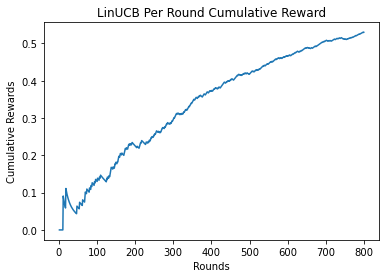

In [9]:
# part b
x = np.linspace(1,800,800)
y = perRoundCumulativeReward(LinUCB_rewards)
plt.plot(x,y)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Rewards")
plt.title("LinUCB Per Round Cumulative Reward")
plt.show()

In [10]:
# part c 
alpha_test_values = [0.001,0.01,0.1,0.5,1,1.5,3]
means = []
for alpha in alpha_test_values:
    mab = LinUCB(10,10,alpha,rng)
    LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    mean = np.mean(LinUCB_rewards)
    means.append(mean)
best_alpha_index = means.index(max(means))
alpha_test_values[best_alpha_index]

0.01

## Task 2: Implement MLinUCB

In [11]:
class MLinUCBArm():
    """MLinUCBArm
    
    Parameters
    ------------
    arm_index: int
        Index of arm.
        
    n_dims: int
        Number of features for each arm. 
        
    alpha: float
        Positive real explore-exploit parameter. 
    
    N: int
        Number of clusters.
    
    m: int
        Number of closest clusters to use when imputing the reward.
    """
    
    def __init__(self, arm_index, n_dims, alpha,N,m):
        self.arm_index = arm_index
        self.n_dims = n_dims
        self.alpha = alpha
        self.N = N 
        self.m = m 
        self.A = np.identity(self.n_dims) 
        self.b = np.zeros((self.n_dims, 1)) 
        self.K_means_model = None
        
    def getUCB(self, context):
        A_inv = np.linalg.inv(self.A)
        x_ta = context[self.arm_index].reshape([-1,1])
        self.theta = np.dot(A_inv, self.b)
        p_ta = np.dot(np.transpose(self.theta), x_ta) + self.alpha * np.sqrt(np.dot(np.transpose(x_ta),np.dot(A_inv,x_ta)))
        return p_ta
        
    def updateArm(self, reward, context):
        self.x_ta = context[self.arm_index, ... ].reshape([-1,1])
        self.A = self.A + np.dot(self.x_ta, np.transpose(self.x_ta))
        self.b = self.b + reward * self.x_ta

In [12]:
class MLinUCB(MAB):
    """MLinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    N : int
        Number of clusters
        
    m : int
        Number of closest clusters to use when imputing the reward.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms = n_arms, rng = rng)
        self.n_dims = n_dims
        self.alpha = alpha
        self.N = N
        self.m = m
        self.mlinucb_arms = [MLinUCBArm(arm_index = i, n_dims = self.n_dims, alpha = self.alpha, 
                                        N = self.N, m = self.m) for i in range(self.n_arms)]
        min_value = min([n_arms, self.N])
        self.reward_arm = {i: [1.0/min_value] for i in range(min_value)}
 
    def play(self, context: ndarray) -> int:
        max_ucb = -1
        max_arm_id = []
        for arm in range(self.n_arms):
            arm_ucb = self.mlinucb_arms[arm].getUCB(context)
            if arm_ucb > max_ucb:
                max_ucb = arm_ucb
                max_arm_id = [arm]
            elif arm_ucb == max_ucb:
                max_arm_id.append(arm)
        best_arm = np.random.choice(max_arm_id)
        self.k_means_model = KMeans(n_clusters=self.N) 
        self.k_means_model.fit(context)
        return best_arm
          
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None, all_rewards = None) -> None:
        if reward is None:
            m_prime = min([self.m, context.shape[0]]) 
            reward_t = 0
            sub_context = context
            cluster_center = self.k_means_model.cluster_centers_
            distances = np.sum(self.k_means_model.transform(sub_context), axis=0)
            clusters = self.k_means_model.predict(sub_context)          
            cluster_distance_space = sorted(tuple(zip(distances,clusters)), key=lambda x: x[0])[:m_prime]
            clusters_to_consider = list(map(lambda x: x[1], cluster_distance_space))
            index = 0
            numerator = 0
            denominator = 1e-10
            for each_cluster in clusters_to_consider:
                selected_cluster = self.reward_arm[each_cluster]
                average_reward = np.sum(selected_cluster) / len(selected_cluster)
                numerator += average_reward / cluster_distance_space[index][0]
                denominator += 1.0 / cluster_distance_space[index][0]
            reward_estimated = numerator / denominator
            self.reward_arm[arm].append(reward_estimated)
            self.mlinucb_arms[arm].updateArm(reward_estimated, context)
        else:
            self.reward_arm[arm].append(reward)
            self.mlinucb_arms[arm].updateArm(reward, context)

In [13]:
# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
rewards_missing = rewards.copy()
rewards_missing[rewards_missing_indicator == 1] = np.nan

In [14]:
# part a
mab = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids]))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, LinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids]))

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

MLinUCB average reward 0.335
LinUCB average reward 0.3275


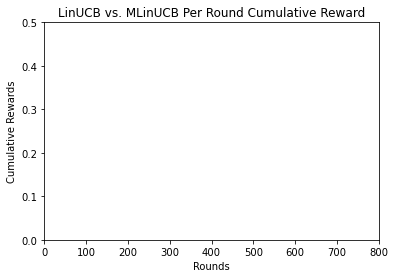

In [15]:
# part b 
x = np.linspace(1,800,800)
y = perRoundCumulativeReward(LinUCB_rewards)
z = perRoundCumulativeReward(MLinUCB_rewards)
plt.plot(x,y)
plt.plot(x,z)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Rewards")
plt.title("LinUCB vs. MLinUCB Per Round Cumulative Reward")
plt.axis([0,800,0,0.5])
plt.show()

In [16]:
# part c 
# tuning alpha
alpha_test_values = [0.001,0.01,0.1,0.5,1,5]
means = []
for alpha in alpha_test_values:
    mab = MLinUCB(10, 10, alpha, 10, 3, rng)
    MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
    mean = np.mean(MLinUCB_rewards)
    means.append(mean)
best_alpha_index = means.index(max(means))
print("best alpha value: ", alpha_test_values[best_alpha_index])

# tuning m
means = []
m_test_values = [1,3,5]        
for m in m_test_values:
    mab = MLinUCB(10, 10, 1.0, 10, m, rng)
    MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
    mean = np.mean(MLinUCB_rewards)
    means.append(mean)
best_m_index = means.index(max(means))
print("best m value: ", m_test_values[best_m_index])

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)


best alpha value:  0.001


<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-12-505591f615f9>:49: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.k_means_model.fit(context)
<ipython-input-

best m value:  1


## Task 3: Implement SquareCB

In [17]:
class SquareCB(MAB):
    """SquareCB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float,
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms = n_arms, rng = rng)
        self.n_dims = n_dims
        self.mu = self.n_arms
        self.gamma = gamma
        self.oracle = {i: (LogisticRegression(), False) for i in range(self.n_arms)}
        self.oracle_trained = False
        self.arm_value = np.zeros(shape=(self.n_arms,))
        self.arm_prob = np.zeros(shape=(self.n_arms))
        self.arm_data = {i: ([], []) for i in range(self.n_arms)}
        
    def play(self, context: ndarray) -> int:
        if not self.oracle_trained:
            indices = []
            for i in range(self.n_arms):
                if not self.oracle[i][1]:
                    indices.append(i)
            if len(indices) != 0:
                return np.random.choice(indices, 1, True)[0]
        self.oracle_trained = True
        for i in range(self.n_arms):
            self.arm_value[i] = self.oracle[i][0].predict(np.concatenate([context[i], [i]]).reshape((1, -1)))
        b_t = np.argmin(self.arm_value)
        sum_ = 0.0
        b_y_t = self.oracle[b_t][0].predict(np.concatenate([context[i], [i]]).reshape((1, -1)))
        for i in range(self.n_arms):
            if i == b_t:
                continue
            a_y_t = self.oracle[i][0].predict(np.concatenate([context[i], [i]]).reshape((1, -1)))
            self.arm_prob[i] = 1.0 / (self.mu + self.gamma * (a_y_t - b_y_t))
        self.arm_prob[b_t] = 0
        self.arm_prob[b_t] = np.abs(1 - np.sum(self.arm_prob))
        np.nan_to_num(np.abs(self.arm_prob), nan=1e-10, copy=False)
        self.arm_prob = np.exp(self.arm_prob) / (np.sum(np.exp(self.arm_prob)))
        sampled_arm = np.random.choice(np.arange(self.n_arms), 1, True, p=np.abs(self.arm_prob))
        return sampled_arm[0]
            
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        model, is_fitted = self.oracle[arm]
        if is_fitted:
            loss_sampled_arm = self.oracle[arm][0].score(np.concatenate([context[arm], [arm]]).reshape((1, -1)), [[int(reward)]])
            (x, y) = self.arm_data[arm]
            x.append(np.squeeze(np.concatenate([context[arm], [arm]]).reshape((1, -1))))
            y.append([np.abs(loss_sampled_arm)])
        else:
            (x, y) = self.arm_data[arm]
            x.append(np.squeeze(np.concatenate([context[arm], [arm]]).reshape((1, -1))))
            y.append([np.abs(reward)])
            if len(np.unique(y)) == 2:
                model.fit(x, np.array(y)[:, 0])
                self.oracle[arm] = (model, True)

In [29]:
# part a
mab = SquareCB(10, 10, 18.0, rng)
SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

SquareCB average reward 0.0925
LinUCB average reward 0.53


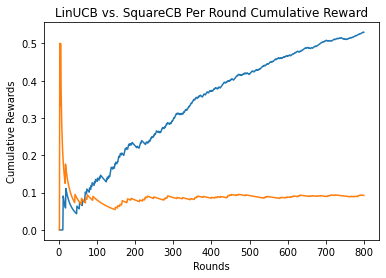

In [30]:
# part b
x = np.linspace(1,800,800)
y = perRoundCumulativeReward(LinUCB_rewards)
z = perRoundCumulativeReward(SquareCB_rewards)
plt.plot(x,y)
plt.plot(x,z)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Rewards")
plt.title("LinUCB vs. SquareCB Per Round Cumulative Reward")
plt.show()

In [32]:
# part c
gamma_test_values = [0.001,0.1,1,5,10,18,25,50]
means = []
for gamma in gamma_test_values:
    mab = LinUCB(10,10,gamma,rng)
    SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    mean = np.mean(SquareCB_rewards)
    means.append(mean)
best_gamma_index = means.index(max(means))
gamma_test_values[best_gamma_index]

0.001